### Quora Data Challenge

In [652]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, ElasticNet

<Figure size 800x640 with 0 Axes>

Suppose you are a Data Scientist on the Mobile team at Quora.<br>The team has just introduced a new UI design to the Quora app.<br>The goal of the new design is to increase user engagement (measured by minutes spent on site). <br>The team ran an A/B test to evaluate the change.<br> Using the data, help the team understand the impact of the UI change better.

Tables provided are as follows:
    1. t1_user_active_min.csv
    2. t2_user_variant.csv
    3. t3_user_active_min_pre.csv
    4. t4_user_attributes.csv

In [653]:
def build_dist(df,df1,col,col1,xlabelvalue,label1,label2):
    sns.distplot(df[col], hist=False, label = label1, axlabel = xlabelvalue)
    sns.distplot(df1[col1], hist=False, label = label2, axlabel = xlabelvalue)
    plt.show()

In [654]:
# reading the data sets
t1_user_active_min     = pd.read_csv("data/t1_user_active_min.csv")
t2_user_variant        = pd.read_csv("data/t2_user_variant.csv")
t3_user_active_min_pre = pd.read_csv("data/t3_user_active_min_pre.csv")
t4_user_attributes     = pd.read_csv("data/t4_user_attributes.csv")
df_list = [t1_user_active_min,t2_user_variant,t3_user_active_min_pre,t4_user_attributes]

In [655]:
t1_user_active_min.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [656]:
t2_user_variant.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [657]:
t2_user_variant['variant_number'].value_counts()

0    40000
1    10000
Name: variant_number, dtype: int64

People in control group: 80 percent <br>
People in treatment group: 20 percent

In [658]:
user_control = []
user_treatment = []
for index,row in t2_user_variant.iterrows():
    if row['variant_number'] == 0:
        user_control.append(row['uid'])
    else:
        user_treatment.append(row['uid'])

In [659]:
t3_user_active_min_pre.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [660]:
t4_user_attributes.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


### Hypothesis:
1. The AB Testing is intended to increase the user engagement in terms of time.
2. Randomized people are used to divide into control and treatment groups.

### KPI for AB Test to look for between treatment and control group:
1. Active time        - increased/ decreased
2. Frequency of visit - increased/decreased
3. Segregation of above two points for old/new users, male/female, reader/non-readers.
4. I will try to look for the combination of all the other factors

#### Creating Analytical Data Table for the user variant - combination of gender/reader/non-reader/days_since_signup

In [661]:
var_gen_ageinquora = pd.merge(t2_user_variant,t4_user_attributes,how = "inner", on = "uid")

In [662]:
var_gen_ageinquora.head()

,uid,variant_number,dt,signup_date,gender,user_type
0,0,0,2019-02-06,2018-09-24,male,non_reader
1,1,0,2019-02-06,2016-11-07,male,reader
2,2,0,2019-02-06,2018-09-17,male,non_reader
3,3,0,2019-02-06,2018-03-04,male,non_reader
4,4,0,2019-02-06,2017-03-09,male,non_reader


In [663]:
var_gen_ageinquora_control = var_gen_ageinquora[var_gen_ageinquora['variant_number'] == 0]
var_gen_ageinquora_treatment = var_gen_ageinquora[var_gen_ageinquora['variant_number'] == 1]
cat_cols = ['gender','user_type']
cont_cols = ['days_since_joined_till_AB_tested']

#### Checking the ratio in treatment and control group

In [664]:
def checkGenderRatioTreatmentControl(df, columnName):
    df = pd.DataFrame(df['gender'].value_counts())
    df.rename(columns = {'gender':columnName}, inplace = True)
    df.reset_index(inplace = True)
    df.rename(columns = {'index':'gender'}, inplace = True)
    return df

In [665]:
treat_gender = checkGenderRatioTreatmentControl(var_gen_ageinquora_treatment, 'count_treat_gender')
control_gender = checkGenderRatioTreatmentControl(var_gen_ageinquora_treatment, 'count_control_gender')

In [666]:
def checkUserTypeRatioTreatmentControl(df, columnName):
    df = pd.DataFrame(df['user_type'].value_counts())
    df.rename(columns = {'user_type':columnName}, inplace = True)
    df.reset_index(inplace = True)
    df.rename(columns = {'index':'user_type'}, inplace = True)
    return df

In [667]:
treat_user_type = checkUserTypeRatioTreatmentControl(var_gen_ageinquora_treatment, 'count_treat_user_type')
control_user_type = checkUserTypeRatioTreatmentControl(var_gen_ageinquora_treatment, 'count_control_user_type')

In [668]:
gender_comparision = pd.merge(treat_gender, control_gender, on = "gender",how = "inner")
user_type_comparision = pd.merge(treat_user_type, control_user_type, on = "user_type",how = "inner")

In [669]:
gender_comparision['treat_ratio'] = gender_comparision['count_treat_gender'] / gender_comparision['count_treat_gender'].sum()
gender_comparision['control_ratio'] = gender_comparision['count_control_gender'] / gender_comparision['count_control_gender'].sum()

In [670]:
gender_comparision.drop(columns = ['count_treat_gender','count_control_gender'])

,gender,treat_ratio,control_ratio
0,male,0.552,0.552
1,female,0.287,0.287
2,unknown,0.161,0.161


In [671]:
user_type_comparision['treat_ratio']   = user_type_comparision['count_treat_user_type'] / user_type_comparision['count_treat_user_type'].sum()
user_type_comparision['control_ratio'] = user_type_comparision['count_control_user_type'] / user_type_comparision['count_control_user_type'].sum()

In [672]:
user_type_comparision.drop(columns = ['count_treat_user_type','count_control_user_type'])

,user_type,treat_ratio,control_ratio
0,non_reader,0.7367,0.7367
1,reader,0.1269,0.1269
2,new_user,0.1235,0.1235
3,contributor,0.0129,0.0129


### After the test is conducted

In [673]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [674]:
uid_control         = list(var_gen_ageinquora_control["uid"])
uid_treatment       = list(var_gen_ageinquora_treatment["uid"])
before_AB_control   = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(uid_control)]
before_AB_treatment = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(uid_treatment)]
after_AB_control    = t1_user_active_min[t1_user_active_min['uid'].isin(uid_control)]
after_AB_treatment  = t1_user_active_min[t1_user_active_min['uid'].isin(uid_treatment)]

In [675]:
# Validating if there is no common elements between control and treatment.
intersection(uid_control, uid_treatment)

[]

In [676]:
after_AB_control_uid    = list(after_AB_control['uid'])
after_AB_treatment_uid  = list(after_AB_treatment['uid'])
before_AB_control_uid   = list(before_AB_control['uid'])
before_AB_treatment_uid = list(before_AB_treatment['uid'])

In [677]:
common_control_uid   = intersection(after_AB_control_uid, before_AB_control_uid)
common_treatment_uid = intersection(after_AB_treatment_uid, before_AB_treatment_uid)

In [678]:
before_AB_control   = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(common_control_uid)]
before_AB_treatment = t3_user_active_min_pre[t3_user_active_min_pre['uid'].isin(common_treatment_uid)]
after_AB_control    = t1_user_active_min[t1_user_active_min['uid'].isin(common_control_uid)]
after_AB_treatment  = t1_user_active_min[t1_user_active_min['uid'].isin(common_treatment_uid)]

In [679]:
before_AB_control.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [680]:
before_AB_control_base_table   = pd.merge(before_AB_control,var_gen_ageinquora, how = "inner", on = "uid")
before_AB_treatment_base_table = pd.merge(before_AB_treatment,var_gen_ageinquora, how = "inner", on = "uid")
after_AB_control_base_table    = pd.merge(after_AB_control,var_gen_ageinquora, how = "inner", on = "uid")
after_AB_treatment_base_table  = pd.merge(after_AB_treatment,var_gen_ageinquora, how = "inner", on = "uid")

In [681]:
before_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_control_base_table.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,0,2018-09-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
1,0,2018-11-08,4.0,0,2019-02-06,2018-09-24,male,non_reader
2,0,2018-11-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
3,0,2018-11-28,6.0,0,2019-02-06,2018-09-24,male,non_reader
4,0,2018-12-02,6.0,0,2019-02-06,2018-09-24,male,non_reader


In [682]:
before_AB_control_base_table.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,0,2018-09-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
1,0,2018-11-08,4.0,0,2019-02-06,2018-09-24,male,non_reader
2,0,2018-11-24,3.0,0,2019-02-06,2018-09-24,male,non_reader
3,0,2018-11-28,6.0,0,2019-02-06,2018-09-24,male,non_reader
4,0,2018-12-02,6.0,0,2019-02-06,2018-09-24,male,non_reader


#### Active minute comparision

In [683]:
# import seaborn as sns
# import plotly.express as px
# fig = px.histogram(before_AB_treatment_base_table_noout, x="active_mins")
# fig.show()

In [684]:
pd.DataFrame(before_AB_control_base_table['active_mins'].describe())

,active_mins
count,978727.00000
mean,35.77256
std,1283.01916
min,1.00000
25%,2.00000
50%,5.00000
75%,15.00000
max,99999.00000


In [685]:
pd.DataFrame(before_AB_treatment_base_table['active_mins'].describe())

,active_mins
count,197942.000000
mean,16.222444
std,503.548367
min,1.000000
25%,2.000000
50%,4.000000
75%,11.000000
max,99999.000000


In [686]:
pd.DataFrame(after_AB_control_base_table['active_mins'].describe())

,active_mins
count,886469.000000
mean,35.361478
std,1266.081303
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,99999.000000


In [687]:
pd.DataFrame(after_AB_treatment_base_table['active_mins'].describe())

,active_mins
count,179291.000000
mean,40.270471
std,1294.258138
min,1.000000
25%,3.000000
50%,7.000000
75%,19.000000
max,99999.000000


In [688]:
after_AB_treatment_base_table.sort_values(by = ['active_mins'], ascending=False)[:5]

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
38650,42198,2019-06-08,99999.0,1,2019-02-06,2016-10-11,male,reader
141896,47957,2019-03-03,99999.0,1,2019-02-06,2013-07-05,male,reader
170027,49503,2019-03-10,99999.0,1,2019-02-06,2017-05-26,male,contributor
125504,47041,2019-04-06,99999.0,1,2019-02-06,2018-12-06,female,reader
170104,49503,2019-06-29,99999.0,1,2019-02-06,2017-05-26,male,contributor


In [689]:
before_AB_treatment_base_table_noout = before_AB_treatment_base_table[before_AB_treatment_base_table.active_mins < np.percentile(before_AB_treatment_base_table.active_mins,92)]
after_AB_treatment_base_table_noout = after_AB_treatment_base_table[after_AB_treatment_base_table.active_mins < np.percentile(after_AB_treatment_base_table.active_mins,92)]

In [690]:
before_AB_treatment_base_table_noout.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,40001,2018-08-12,1.0,1,2019-02-06,2017-04-29,male,non_reader
1,40001,2018-08-21,1.0,1,2019-02-06,2017-04-29,male,non_reader
2,40001,2018-09-21,5.0,1,2019-02-06,2017-04-29,male,non_reader
3,40001,2018-09-23,3.0,1,2019-02-06,2017-04-29,male,non_reader
4,40001,2018-10-03,1.0,1,2019-02-06,2017-04-29,male,non_reader


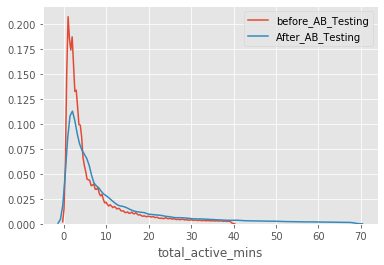

In [691]:
build_dist(before_AB_treatment_base_table_noout,after_AB_treatment_base_table_noout,
           "active_mins","active_mins","total_active_mins", "before_AB_Testing","After_AB_Testing")

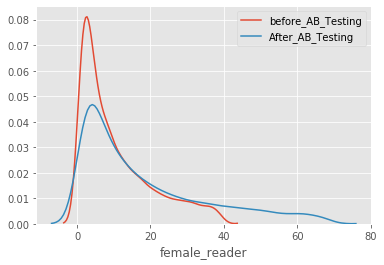

In [692]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "female")&(before_AB_treatment_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","female_reader", "before_AB_Testing","After_AB_Testing")


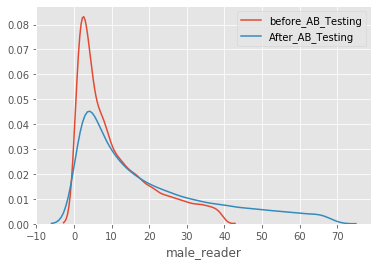

In [693]:


build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","male_reader", "before_AB_Testing","After_AB_Testing")


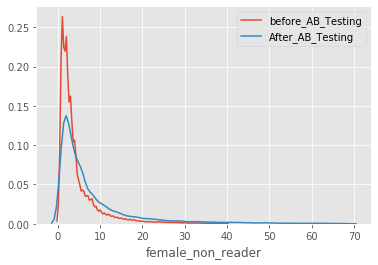

In [694]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "female")&(before_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins","female_non_reader", "before_AB_Testing","After_AB_Testing")


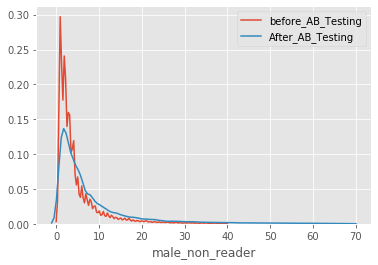

In [695]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins", "male_non_reader", "before_AB_Testing","After_AB_Testing")


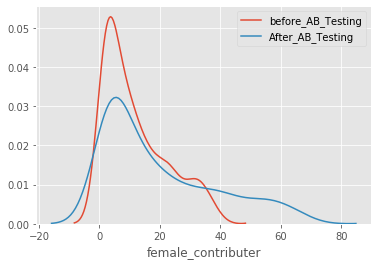

In [696]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "unknown")&(before_AB_treatment_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "unknown")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","female_contributer", "before_AB_Testing","After_AB_Testing")

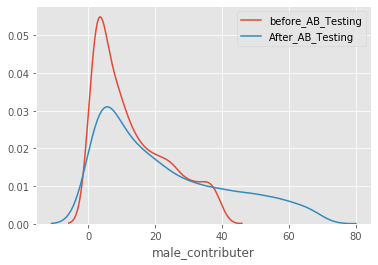

In [697]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","male_contributer", "before_AB_Testing","After_AB_Testing")


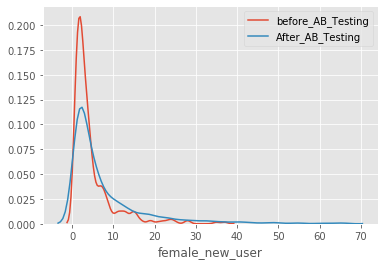

In [698]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "female")&(before_AB_treatment_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","female_new_user", "before_AB_Testing","After_AB_Testing")

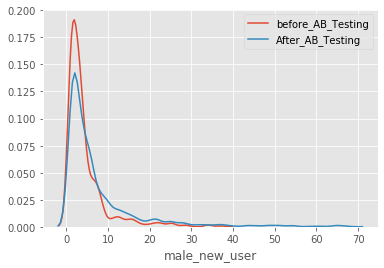

In [699]:

build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "male")&(before_AB_treatment_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","male_new_user", "before_AB_Testing","After_AB_Testing")

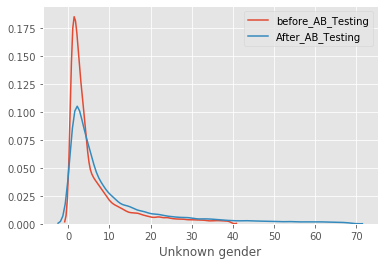

In [700]:
build_dist(before_AB_treatment_base_table_noout[(before_AB_treatment_base_table_noout["gender"] == "unknown")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "unknown")],
           "active_mins","active_mins","Unknown gender", "before_AB_Testing","After_AB_Testing")

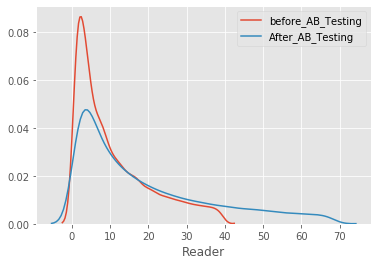

In [701]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "reader"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "reader"],
           "active_mins","active_mins","Reader", "before_AB_Testing","After_AB_Testing")

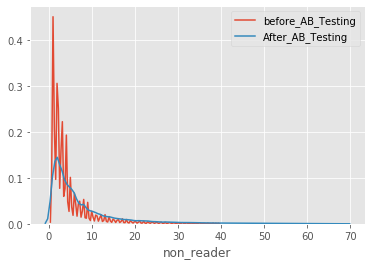

In [702]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "non_reader"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "non_reader"],
           "active_mins","active_mins","non_reader", "before_AB_Testing","After_AB_Testing")

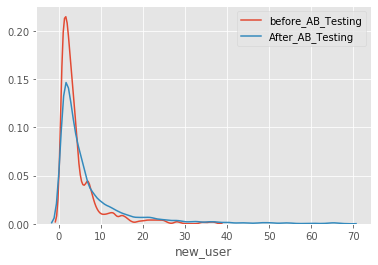

In [703]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "new_user"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "new_user"],
           "active_mins","active_mins","new_user", "before_AB_Testing","After_AB_Testing")

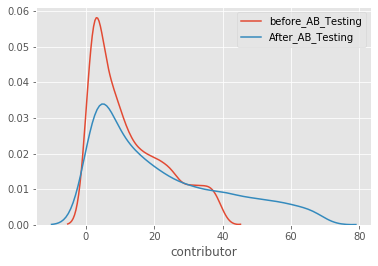

In [704]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["user_type"] == "contributor"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["user_type"] == "contributor"],
           "active_mins","active_mins","contributor", "before_AB_Testing","After_AB_Testing")

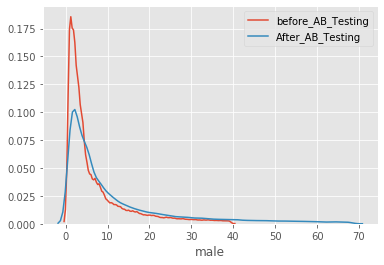

In [705]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["gender"] == "male"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["gender"] == "male"],
           "active_mins","active_mins","male", "before_AB_Testing","After_AB_Testing")

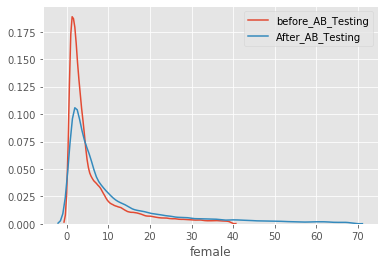

In [706]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["gender"] == "female"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["gender"] == "female"],
           "active_mins","active_mins","female", "before_AB_Testing","After_AB_Testing")

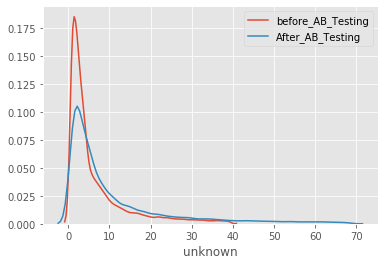

In [707]:
build_dist(before_AB_treatment_base_table_noout[before_AB_treatment_base_table_noout["gender"] == "unknown"],
           after_AB_treatment_base_table_noout[after_AB_treatment_base_table_noout["gender"] == "unknown"],
           "active_mins","active_mins","unknown", "before_AB_Testing","After_AB_Testing")

## Trying to see the change in number of visits over the entire data

In [708]:
# Changing to date data-type
before_AB_treatment_base_table_noout['AB_Date'] = pd.to_datetime(before_AB_treatment_base_table_noout['AB_Date'])
before_AB_treatment_base_table_noout['signup_date'] = pd.to_datetime(before_AB_treatment_base_table_noout['signup_date'])
before_AB_treatment_base_table_noout.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type
0,40001,2018-08-12,1.0,1,2019-02-06,2017-04-29,male,non_reader
1,40001,2018-08-21,1.0,1,2019-02-06,2017-04-29,male,non_reader
2,40001,2018-09-21,5.0,1,2019-02-06,2017-04-29,male,non_reader
3,40001,2018-09-23,3.0,1,2019-02-06,2017-04-29,male,non_reader
4,40001,2018-10-03,1.0,1,2019-02-06,2017-04-29,male,non_reader


In [709]:
user_count_before_AB = pd.DataFrame(before_AB_treatment_base_table_noout['uid'].value_counts())
user_count_before_AB.reset_index(inplace = True)
user_count_before_AB.rename(columns = {'uid':'before_count', 'index':'uid'}, inplace = True)
user_count_after_AB = pd.DataFrame(after_AB_treatment_base_table_noout['uid'].value_counts())
user_count_after_AB.reset_index(inplace = True)
user_count_after_AB.rename(columns = {'uid':'after_count', 'index':'uid'}, inplace = True)

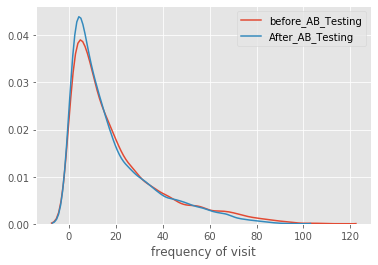

In [710]:
build_dist(user_count_before_AB,user_count_after_AB,'before_count','after_count','frequency of visit', "before_AB_Testing","After_AB_Testing")

In [711]:
frequency_AB_effect = pd.merge(user_count_before_AB, user_count_after_AB, how = "inner", on = "uid")
sample_df = pd.DataFrame(after_AB_treatment_base_table_noout.groupby(['uid'])[['gender','user_type']].min())

frequency_AB_effect = pd.merge(frequency_AB_effect, sample_df, how = "left", on = "uid")
visit_increased_0_1 = []
attribute_visit_increased = []
attribute_visit_decreased = []
for index,row in frequency_AB_effect.iterrows():
    if row['after_count'] > row['before_count']:
        visit_increased_0_1.append(1)
        attribute_visit_increased.append([row['gender'],row['user_type']])
    else:
        visit_increased_0_1.append(0)
        attribute_visit_decreased.append([row['gender'],row['user_type']])
        
        
a = pd.DataFrame(attribute_visit_increased)
b = pd.DataFrame(attribute_visit_decreased)


analysis_increased_gender = pd.DataFrame(a[0].value_counts())
analysis_increased_gender.reset_index(inplace = True)

analysis_increased_gender.rename(columns = {0:'visit_increased_after_AB_Testing', 'index':'gender'}, inplace = True)

analysis_increased_user_type= pd.DataFrame(a[1].value_counts())
analysis_increased_user_type.reset_index(inplace = True)

analysis_increased_user_type.rename(columns = {1:'visit_increased_after_AB_Testing', 'index':'user_type'}, inplace = True)

analysis_decreased_gender = pd.DataFrame(b[0].value_counts())
analysis_decreased_gender.reset_index(inplace = True)

analysis_decreased_gender.rename(columns = {0:'visit_decreased_after_AB_Testing', 'index':'gender'}, inplace = True)

analysis_decreased_user_type= pd.DataFrame(b[1].value_counts())
analysis_decreased_user_type.reset_index(inplace = True)
analysis_decreased_user_type.rename(columns = {1:'visit_decreased_after_AB_Testing', 'index':'user_type'}, inplace = True)

analysis_gender_AB = pd.merge(analysis_increased_gender, analysis_decreased_gender,
                             how = "inner", on = "gender")

analysis_usertype_AB = pd.merge(analysis_increased_user_type, analysis_decreased_user_type,
                             how = "inner", on = "user_type")

In [712]:
analysis_usertype_AB.head()

,user_type,visit_increased_after_AB_Testing,visit_decreased_after_AB_Testing
0,non_reader,2554,4451
1,new_user,546,223
2,reader,455,804
3,contributor,49,77


In [713]:
analysis_gender_AB.head()

,gender,visit_increased_after_AB_Testing,visit_decreased_after_AB_Testing
0,male,1995,3127
1,female,1044,1545
2,unknown,565,883


## Trying to see the change in amount of time spent over the entire data

In [714]:
before_AB = pd.DataFrame(before_AB_treatment_base_table_noout.groupby(['uid'])['active_mins'].sum())
after_AB = pd.DataFrame(after_AB_treatment_base_table_noout.groupby(['uid'])['active_mins'].sum())
after_AB.reset_index(inplace = True)
after_AB.rename(columns = {'active_mins':'total_active_time_after_AB_testing'}, inplace = True)
before_AB.reset_index(inplace = True)
before_AB.rename(columns = {'active_mins':'total_active_time_before_AB_testing'}, inplace = True)

active_min_AB_testing_analysis = pd.merge(before_AB,after_AB, on = "uid", how = "inner")
active_min_AB_testing_analysis = pd.merge(active_min_AB_testing_analysis,
                                          t4_user_attributes, how = 'left', on = "uid")

visit_increased_0_1 = []
attribute_visit_increased = []
attribute_visit_decreased = []
for index,row in active_min_AB_testing_analysis.iterrows():
    if row['total_active_time_after_AB_testing'] > row['total_active_time_before_AB_testing']:
        visit_increased_0_1.append(1)
        attribute_visit_increased.append([row['gender'],row['user_type']])
    else:
        visit_increased_0_1.append(0)
        attribute_visit_decreased.append([row['gender'],row['user_type']])
        
        
a = pd.DataFrame(attribute_visit_increased)
b = pd.DataFrame(attribute_visit_decreased)


time_increased_gender = pd.DataFrame(a[0].value_counts())
time_increased_gender.reset_index(inplace = True)

time_increased_gender.rename(columns = {0:'time_increased_after_AB_Testing', 'index':'gender'}, inplace = True)

time_increased_user_type= pd.DataFrame(a[1].value_counts())
time_increased_user_type.reset_index(inplace = True)

time_increased_user_type.rename(columns = {1:'time_increased_after_AB_Testing', 'index':'user_type'}, inplace = True)

time_decreased_gender = pd.DataFrame(b[0].value_counts())
time_decreased_gender.reset_index(inplace = True)

time_decreased_gender.rename(columns = {0:'time_decreased_after_AB_Testing', 'index':'gender'}, inplace = True)

time_decreased_user_type= pd.DataFrame(b[1].value_counts())
time_decreased_user_type.reset_index(inplace = True)
time_decreased_user_type.rename(columns = {1:'time_decreased_after_AB_Testing', 'index':'user_type'}, inplace = True)

time_analysis_gender_AB = pd.merge(time_increased_gender, time_decreased_gender,
                             how = "inner", on = "gender")

time_analysis_usertype_AB = pd.merge(time_increased_user_type, time_decreased_user_type,
                             how = "inner", on = "user_type")

In [715]:
time_analysis_gender_AB.head()

,gender,time_increased_after_AB_Testing,time_decreased_after_AB_Testing
0,male,3280,1842
1,female,1604,985
2,unknown,894,554


In [716]:
time_analysis_usertype_AB.head()

,user_type,time_increased_after_AB_Testing,time_decreased_after_AB_Testing
0,non_reader,4165,2840
1,reader,915,344
2,new_user,608,161
3,contributor,90,36


#### Between control and treatment group 

In [717]:
after_AB_control_base_table_noout = after_AB_control_base_table[after_AB_control_base_table.active_mins < np.percentile(after_AB_control_base_table.active_mins,92)]
after_AB_treatment_base_table_noout = after_AB_treatment_base_table[after_AB_treatment_base_table.active_mins < np.percentile(after_AB_treatment_base_table.active_mins,92)]

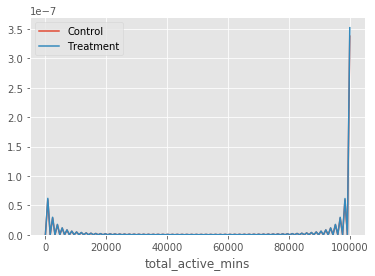

In [718]:
build_dist(after_AB_control_base_table,after_AB_treatment_base_table,
           "active_mins","active_mins","total_active_mins","Control","Treatment")

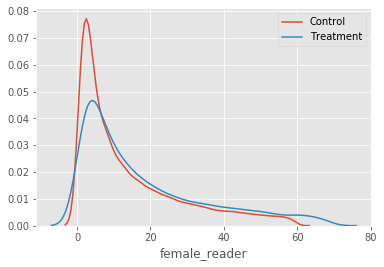

In [719]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "female")&(after_AB_control_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","female_reader","Control","Treatment")

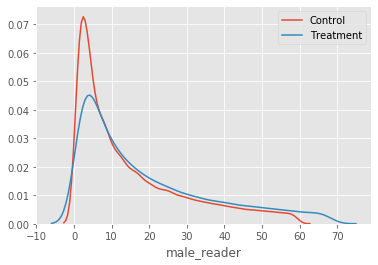

In [720]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "male")&(after_AB_control_base_table_noout["user_type"] == "reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "reader")],
           "active_mins","active_mins","male_reader", "Control", "Treatment")

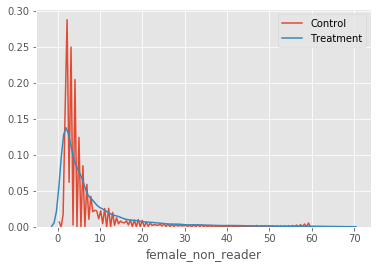

In [721]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "female")&(after_AB_control_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins","female_non_reader", "Control", "Treatment")

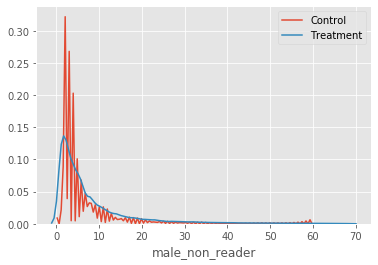

In [722]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "male")&(after_AB_control_base_table_noout["user_type"] == "non_reader")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "non_reader")],
           "active_mins","active_mins", "male_non_reader", "Control", "Treatment")

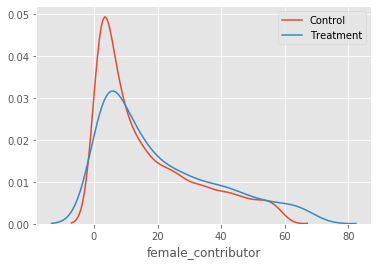

In [723]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "female")&(after_AB_control_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","female_contributor", "Control", "Treatment")

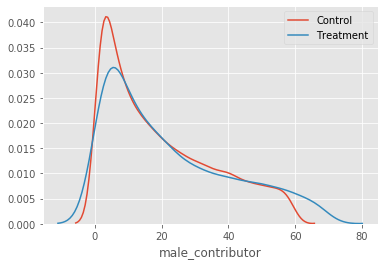

In [724]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "male")&(after_AB_control_base_table_noout["user_type"] == "contributor")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "contributor")],
           "active_mins","active_mins","male_contributor", "Control", "Treatment")

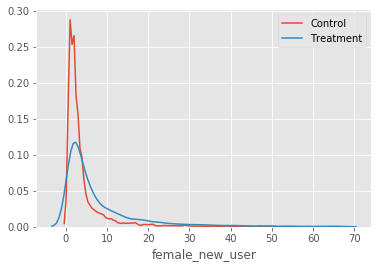

In [725]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "female")&(after_AB_control_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "female")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","female_new_user", "Control", "Treatment")

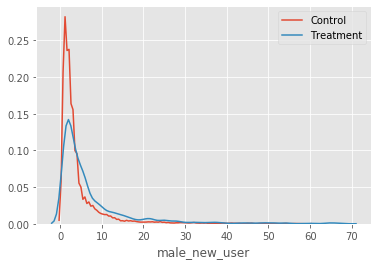

In [726]:
build_dist(after_AB_control_base_table_noout[(after_AB_control_base_table_noout["gender"] == "male")&(after_AB_control_base_table_noout["user_type"] == "new_user")],
           after_AB_treatment_base_table_noout[(after_AB_treatment_base_table_noout["gender"] == "male")&(after_AB_treatment_base_table_noout["user_type"] == "new_user")],
           "active_mins","active_mins","male_new_user", "Control", "Treatment")

#### Regrression and p-value analysis

In [727]:
before_AB_treatment_base_table['date'] = pd.to_datetime(before_AB_treatment_base_table['date'])
before_AB_treatment_base_table['AB_Date'] = pd.to_datetime(before_AB_treatment_base_table['AB_Date'])
before_AB_treatment_base_table['signup_date'] = pd.to_datetime(before_AB_treatment_base_table['signup_date'])

before_AB_control_base_table['date'] = pd.to_datetime(before_AB_control_base_table['date'])
before_AB_control_base_table['AB_Date'] = pd.to_datetime(before_AB_control_base_table['AB_Date'])
before_AB_control_base_table['signup_date'] = pd.to_datetime(before_AB_control_base_table['signup_date'])

after_AB_control_base_table['date'] = pd.to_datetime(after_AB_control_base_table['date'])
after_AB_control_base_table['AB_Date'] = pd.to_datetime(after_AB_control_base_table['AB_Date'])
after_AB_control_base_table['signup_date'] = pd.to_datetime(after_AB_control_base_table['signup_date'])

after_AB_treatment_base_table['date'] = pd.to_datetime(after_AB_treatment_base_table['date'])
after_AB_treatment_base_table['AB_Date'] = pd.to_datetime(after_AB_treatment_base_table['AB_Date'])
after_AB_treatment_base_table['signup_date'] = pd.to_datetime(after_AB_treatment_base_table['signup_date'])

In [728]:
before_AB_treatment_base_table['days_since_signup'] = before_AB_treatment_base_table['AB_Date'] - before_AB_treatment_base_table['signup_date']
before_AB_treatment_base_table['days_since_signup'] = before_AB_treatment_base_table['days_since_signup'].apply(lambda x:x.days)

before_AB_control_base_table['days_since_signup'] = before_AB_control_base_table['AB_Date'] - before_AB_control_base_table['signup_date']
before_AB_control_base_table['days_since_signup'] = before_AB_control_base_table['days_since_signup'].apply(lambda x:x.days)

after_AB_control_base_table['days_since_signup'] = after_AB_control_base_table['AB_Date'] - after_AB_control_base_table['signup_date']
after_AB_control_base_table['days_since_signup'] = after_AB_control_base_table['days_since_signup'].apply(lambda x:x.days)

after_AB_treatment_base_table['days_since_signup'] = after_AB_treatment_base_table['AB_Date'] - after_AB_treatment_base_table['signup_date']
after_AB_treatment_base_table['days_since_signup'] = after_AB_treatment_base_table['days_since_signup'].apply(lambda x:x.days)

In [729]:
after_AB_treatment_base_table.head()

,uid,date,active_mins,variant_number,AB_Date,signup_date,gender,user_type,days_since_signup
0,40001,2019-02-14,16.0,1,2019-02-06,2017-04-29,male,non_reader,648
1,40001,2019-02-17,5.0,1,2019-02-06,2017-04-29,male,non_reader,648
2,40001,2019-02-22,16.0,1,2019-02-06,2017-04-29,male,non_reader,648
3,40001,2019-02-24,5.0,1,2019-02-06,2017-04-29,male,non_reader,648
4,40001,2019-02-25,34.0,1,2019-02-06,2017-04-29,male,non_reader,648


In [730]:
col_to_drop = ['date','AB_Date','signup_date']

In [731]:
def mapMaleFemale(df):
    return df['gender'].map({'female':0, 'male':1})

In [732]:
before_AB_treatment_base_table['gender'] = mapMaleFemale(before_AB_treatment_base_table)
before_AB_control_base_table['gender'] = mapMaleFemale(before_AB_control_base_table)
after_AB_control_base_table['gender'] = mapMaleFemale(after_AB_control_base_table)
after_AB_treatment_base_table['gender'] = mapMaleFemale(after_AB_treatment_base_table)

In [733]:
def finalizeDataTables(df, col_to_drop, generateFile):
    # dum_1 = pd.get_dummies(before_AB_control_base_table['gender'])
    dum_2 = pd.get_dummies(df['user_type'])
    df = pd.concat([df,dum_2], axis = 1)
    df.drop(columns = col_to_drop, inplace = True)
    a = pd.DataFrame(df['uid'].value_counts())
    a.reset_index(inplace = True)
    a.rename(columns = {'uid':'appearences','index':'uid'}, inplace = True)
    df = pd.merge(df,a,how = "inner",on = "uid")
    col_to_group_by = list(df.columns)
    col_to_group_by.remove('active_mins')
    df = pd.DataFrame(df.groupby(col_to_group_by)['active_mins'].sum())
    df.reset_index(inplace = True)
    df.drop(columns = ['user_type'], inplace = True)
    df['avg_time_per_user'] = df['active_mins']/df['appearences']
    if generateFile:
        df.to_csv(df+".csv", index = False)
    return df

In [734]:
before_AB_control_base_table = finalizeDataTables(before_AB_control_base_table, col_to_drop, False)
before_AB_treatment_base_table = finalizeDataTables(before_AB_treatment_base_table, col_to_drop, False)
after_AB_control_base_table = finalizeDataTables(after_AB_control_base_table, col_to_drop, False)
after_AB_treatment_base_table = finalizeDataTables(after_AB_treatment_base_table, col_to_drop, False)

### Analysis

In [739]:
before_AB_control_base_table.describe()

,uid,variant_number,gender,days_since_signup,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,31650.000000,31650.0,31650.000000,31650.000000,31650.000000,31650.000000,31650.000000,31650.000000,31650.000000,3.165000e+04,31650.000000
mean,19973.209036,0.0,0.661959,674.084455,0.025750,0.057567,0.730079,0.186603,26.944518,9.943729e+02,14.243963
std,11539.191511,0.0,0.473050,628.719814,0.158392,0.232927,0.443926,0.389599,27.652389,1.803092e+04,188.729459
min,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00,1.000000
25%,10011.250000,0.0,0.000000,174.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2.200000e+01,2.666667
50%,19932.500000,0.0,1.000000,508.000000,0.000000,0.000000,1.000000,0.000000,17.000000,6.400000e+01,4.000000
75%,29990.750000,0.0,1.000000,999.750000,0.000000,0.000000,1.000000,0.000000,37.000000,2.230000e+02,7.500000
max,39999.000000,0.0,1.000000,17933.000000,1.000000,1.000000,1.000000,1.000000,133.000000,1.345714e+06,15448.000000


In [740]:
before_AB_treatment_base_table.describe()

,uid,variant_number,gender,days_since_signup,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,7716.000000,7716.0,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000
mean,44994.667963,1.0,0.664075,661.974857,0.013997,0.081001,0.764515,0.140487,22.000130,367.234966,8.107847
std,2888.706413,0.0,0.472344,622.148086,0.117485,0.272854,0.424329,0.347514,23.071837,5248.467476,60.544841
min,40001.000000,1.0,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,42474.750000,1.0,0.000000,154.000000,0.000000,0.000000,1.000000,0.000000,6.000000,19.000000,2.666667
50%,44997.000000,1.0,1.000000,496.500000,0.000000,0.000000,1.000000,0.000000,14.000000,52.000000,3.936835
75%,47494.250000,1.0,1.000000,1004.250000,0.000000,0.000000,1.000000,0.000000,29.000000,159.000000,6.800000
max,49999.000000,1.0,1.000000,3169.000000,1.000000,1.000000,1.000000,1.000000,126.000000,439073.000000,3818.026087


In [741]:
after_AB_control_base_table.describe()

,uid,variant_number,gender,days_since_signup,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,31650.000000,31650.0,31650.000000,31650.000000,31650.000000,31650.000000,31650.000000,31650.000000,31650.000000,31650.000000,31650.000000
mean,19973.209036,0.0,0.661959,674.084455,0.025750,0.057567,0.730079,0.186603,24.444265,854.845118,12.947365
std,11539.191511,0.0,0.473050,628.719814,0.158392,0.232927,0.443926,0.389599,24.636011,14210.400413,151.027873
min,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,10011.250000,0.0,0.000000,174.000000,0.000000,0.000000,0.000000,0.000000,6.000000,17.000000,2.500000
50%,19932.500000,0.0,1.000000,508.000000,0.000000,0.000000,1.000000,0.000000,15.000000,55.000000,3.758940
75%,29990.750000,0.0,1.000000,999.750000,0.000000,0.000000,1.000000,0.000000,35.000000,205.000000,7.101531
max,39999.000000,0.0,1.000000,17933.000000,1.000000,1.000000,1.000000,1.000000,110.000000,937182.000000,10250.846154


In [742]:
after_AB_treatment_base_table.describe()

,uid,variant_number,gender,days_since_signup,contributor,new_user,non_reader,reader,appearences,active_mins,avg_time_per_user
count,7716.000000,7716.0,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000,7716.000000
mean,44994.667963,1.0,0.664075,661.974857,0.013997,0.081001,0.764515,0.140487,19.955029,811.369362,15.835082
std,2888.706413,0.0,0.472344,622.148086,0.117485,0.272854,0.424329,0.347514,20.611335,10698.794860,119.248676
min,40001.000000,1.0,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,42474.750000,1.0,0.000000,154.000000,0.000000,0.000000,1.000000,0.000000,5.000000,24.000000,3.908381
50%,44997.000000,1.0,1.000000,496.500000,0.000000,0.000000,1.000000,0.000000,12.000000,73.000000,6.000000
75%,47494.250000,1.0,1.000000,1004.250000,0.000000,0.000000,1.000000,0.000000,27.000000,237.000000,10.784325
max,49999.000000,1.0,1.000000,3169.000000,1.000000,1.000000,1.000000,1.000000,107.000000,646736.000000,6044.261682


In [760]:
X = before_AB_control_base_table[before_AB_control_base_table.columns.difference(['active_mins', 'uid', 'variant_number','reader',
                                                                                  'non_reader', 'contributor', 'gender', 'new_user'])]
y = before_AB_control_base_table.loc[:,'active_mins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test) # make the predictions by the model
p_value_dict = dict(model.pvalues)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            active_mins   R-squared (uncentered):                   0.836
Model:                            OLS   Adj. R-squared (uncentered):              0.836
Method:                 Least Squares   F-statistic:                          4.300e+04
Date:                Tue, 15 Sep 2020   Prob (F-statistic):                        0.00
Time:                        23:02:48   Log-Likelihood:                     -2.6262e+05
No. Observations:               25320   AIC:                                  5.252e+05
Df Residuals:                   25317   BIC:                                  5.253e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
appearences          12.8635      1.724      7.461      0.000       9.484      16.243
avg_time_per_user    86.4038      0.243    355.210      0.000      85.927      86.881
days_since_signup    -0.3860      0.072     -5.377      0.000      -0.527      -0.245
==============================================================================
Omnibus:                    79623.532   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      39615108414.168
Skew:                         -49.170   Prob(JB):                         0.00
Kurtosis:                    6130.005   Cond. No.                         32.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Performing the t-test

In [771]:
import scipy.stats as stats

#perform two sample t-test with equal variances
stats.ttest_ind(a=np.array(after_AB_control_base_table['avg_time_per_user']),
                b=np.array(after_AB_treatment_base_table['avg_time_per_user']), equal_var=True)

Ttest_indResult(statistic=-1.5648337128636616, pvalue=0.1176299431340109)

In [763]:
import scipy.stats as stats

stats.f_oneway(after_AB_control_base_table['avg_time_per_user'],
               after_AB_treatment_base_table['avg_time_per_user'])

F_onewayResult(statistic=2.4487045489146726, pvalue=0.11762994313245233)